# Diffusion model

## Imports


In [ ]:
# Import the PyTorch library for tensor operations.
import torch

# Import the neural network module from PyTorch.
import torch.nn as nn

# Import functional operations from PyTorch.
import torch.nn.functional as F

# Import the 'numpy' library for numerical operations.
import numpy as np

# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam

# Import the DataLoader class from PyTorch for handling datasets.
from torch.utils.data import DataLoader

# Import data transformation functions from torchvision.
import torchvision.transforms as transforms

# Import the MNIST dataset from torchvision.
from torchvision.datasets import MNIST

# Import 'tqdm' for creating progress bars during training.
import tqdm

# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm

# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import LambdaLR

# Import the 'matplotlib.pyplot' library for plotting graphs.
import matplotlib.pyplot as plt

# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math

## Simple forward diffusion

## Creating basic forward diffusion

Let’s begin with forward diffusion. In basic terms, the diffusion equation is:

![Forward Diffusion Equation](https://cdn-images-1.medium.com/max/8976/1*UUsPUx1QVfT-w6m9rp70sw.png)

Here, σ(***t***)>0 is the **noise strength**, **Δ*t*** is the **step size**, and **r∼N(0,1)** is a **standard normal random variable**. Simply put, we keep adding normally-distributed noise to our sample. Usually, the noise strength ***σ*(*t*)** is chosen to increase with time (as *t* gets larger).

In [2]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

In [3]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

In [4]:
def noise_strength_linear(t):
    """
    Example noise strength function that returns a linear value based on time.

    Parameters:
    - t: Time parameter

    Returns:
    - Linear noise strength (equal to time)
    """
    return t



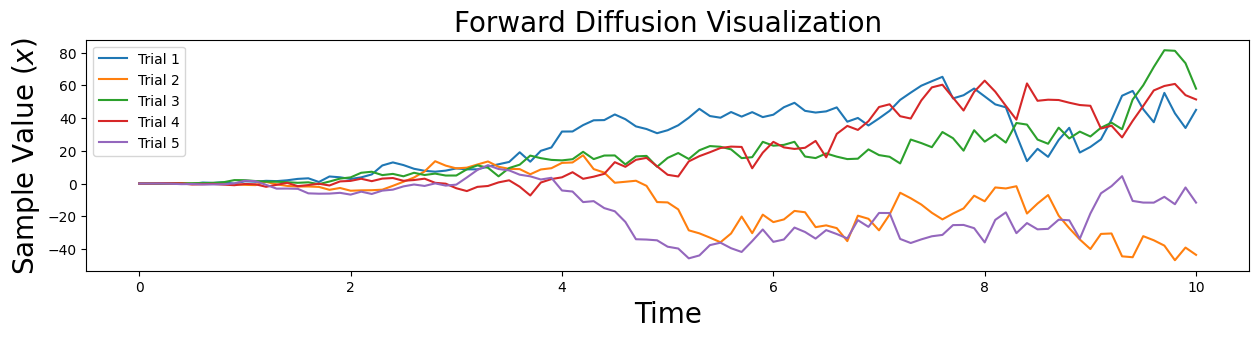

In [5]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_linear

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()


This visualization illustrates the forward diffusion process, which can be understood as slowly introducing noise to the starting sample. This leads to the creation of various samples as the diffusion process progresses, as depicted in the graph.

## Reverse diffusion process


To undo this diffusion process, we use a similar update rule:

![Reverse Diffusion Equation](https://cdn-images-1.medium.com/max/17044/1*y7HnA0G91dn338gay1GKDA.png)

**s(x,t)** is known as the **score function**. Knowing this function allows us to reverse the forward diffusion and convert noise back into our initial state.

If our starting point is always just one point at ***x*0​=0**, and the noise strength is constant, then the score function is exactly equal to

![Score function when noise strength is constant](https://cdn-images-1.medium.com/max/9160/1*nLumpTF2q9gqdwV5SMRNqQ.png)

Now that we know the mathematical equations, let’s first code the 1D reverse diffusion function.


In [6]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [7]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

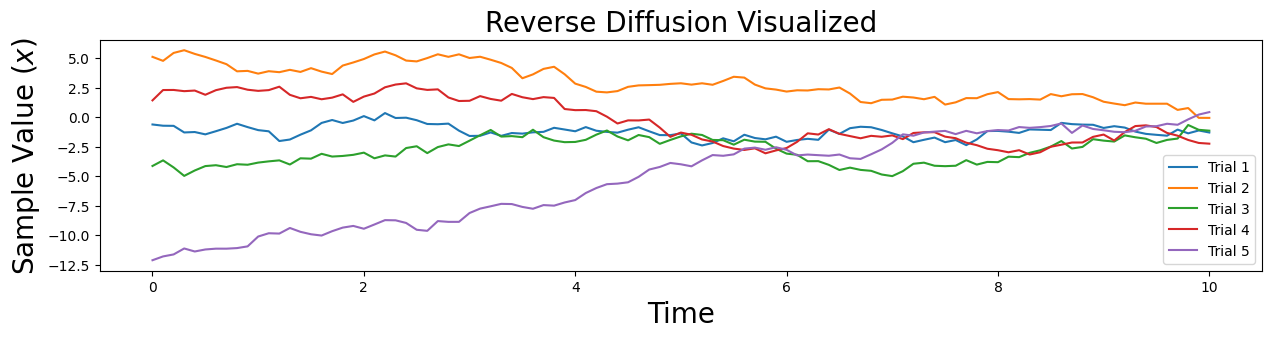

In [8]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

## Score function 


In real-world scenarios, we start without knowledge of the score function, our goal is to learn it. One approach involves training a neural network to **‘denoise’** samples using the denoising objective:

![denoising objective equation](https://cdn-images-1.medium.com/max/16188/1*ISU3X_VXowq3pYCxNdCkeg.png)

Here, **p0​(x0​)** represents our **target distribution** (e.g., images of cars and cats), and **x(*noised)**​ denotes the sample from **the target distribution x0​** after a single forward diffusion step. In simpler terms, [ x(noised) ​− x0 ]​ is essentially a **normally-distributed** random variable.

Expressing the same idea in a way closer to the actual implementation:

![other way to write denoising objective equation](https://cdn-images-1.medium.com/max/16224/1*-qIF57sPHuf_vMs4MHLNww.png)

It’s important to understand the concept that our aim is to predict the amount of noise added to each part of our sample effectively at every time *t* in the diffusion process and for every *x*0​ in our original distribution (cars, cats, etc.)

In these expressions:

* *J* represents the denoising objective.

* E denotes the expectation.

* *t* represents the time parameter.

* *x*0​ is a sample from the target distribution *p*0​(*x*0​).

* *x(*noised)​ represents the target distribution sample *x*0​ after one forward diffusion step.

* *s*(⋅,⋅) represents the score function.

* *σ*(*t*) is a function of time.

* *ϵ* is a normally-distributed random variable.

So far, we’ve covered the basics of how forward and backward diffusion work, and we’ve explored how to learn our score function.


## Time Embedding for Neural Network

Learning the score function involves turning random noise into meaningful structure. To achieve this, we use a neural network to approximate the score function. Since we're working with images, the network must be well-suited to image data. Additionally, because the score function depends on time, we need a way for the network to accurately account for temporal variations. This is where time embeddings come in.

Rather than feeding the network a single scalar time value, we encode time using a set of sinusoidal features. These rich representations help the network better adapt to changes over time, improving its ability to learn the time-dependent score function s(x, t).

To make the network time-aware, we introduce two key modules.

In [9]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

The **`GaussianFourierProjection`** function is designed to generate a module that creates Gaussian random features to represent time steps in a neural network. When initialized, the module samples a set of random frequencies from a Gaussian distribution. These frequencies remain fixed during training and are not updated during optimization.

When we pass an input tensor `x` (representing time steps) through the module, it computes:

**sin(x * f)**
**cos(x * f)**
where f are the fixed random frequencies. These sine and cosine projections are then concatenated to form a rich, high-dimensional embedding of x.

This approach enables the model to capture complex temporal patterns by projecting scalar time inputs into a space where they can be more easily processed by a neural network. It’s particularly useful in tasks like diffusion models, where encoding the notion of time is crucial to learning the time-dependent score function.

In [10]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

The Dense module is designed to transform the output of a fully connected layer into a 4D tensor, effectively converting it into a feature map. It takes two arguments: the dimensionality of the input `(input_dim)` and the desired output dimensionality `(output_dim)`.

During the forward pass, the input tensor x is first passed through the fully connected layer `(self.dense(x))`, producing a 2D output of shape `[batch_size, output_dim]`. To make this output compatible with convolutional layers, two singleton dimensions are added at the end using `[..., None, None]`, reshaping it to `[batch_size, output_dim, 1, 1]`.

This reshaping broadcasts the output across spatial dimensions, making it suitable for further processing in convolution-based architectures.

## U-NET Architecture (simple)

### U-Net with concatenation

When dealing with images, our neural network needs to work seamlessly with them and capture the inherent features associated with images.

We opt for a [U-Net architecture](https://www.geeksforgeeks.org/u-net-architecture-explained/), which combines a CNN-like structure with downscaling/upscaling operations. This combination helps the network focus on image features at different spatial scales.

In [11]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        # We concatenate the output of the tconv4 layer with h3
        # to create a skip connection
        h = self.tconv3(torch.cat([h, h3], dim=1)) 
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

### U-Net with addition

In [12]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        # We addition the output of the tconv4 layer with h3
        # to create a skip connection
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

The UNet_res model we have implemented is a variation of the standard UNet architecture. While both models share the U-Net framework, the main distinction lies in the implementation of skip connections. In the original UNet model, skip connections concatenate tensors from the encoding path with those in the decoding path. In contrast, the UNet_res model directly adds tensors from the encoding path to the corresponding tensors in the decoding path. This difference in skip connection strategy may impact the flow of information and the interactions between different resolution levels, potentially influencing the model's ability to capture features and dependencies in the data.

### Forward process

#### Forward Diffusion Process with Exponential Noise

We will define the specific forward diffusion process:

![forward diffusion equation](https://cdn-images-1.medium.com/max/4800/1*Ou_YMRL_KT-FNoF8G9Ausg.png)

This formula represents a dynamic system where the variable *x* changes over time (*t*) with the introduction of noise (*dw*). The noise level is determined by the parameter *σ*, and it increases exponentially as time progresses.

Given this process and an initial value *x*(0), we can find an analytical solution for *x*(*t*):

![Analytical solution for the sample](https://cdn-images-1.medium.com/max/8940/1*qxi_K5tx1CIl7JSlLniaSg.png)

In this context, *σ*(*t*) is referred to as the marginal standard deviation. Essentially, it represents the variability of the distribution of *x*(*t*) given the initial value *x*(0).

For our specific case, the marginal standard deviation is calculated as:

![marginal standard deviation equation](https://cdn-images-1.medium.com/max/12416/1*09vg7fc0iLae3XsiI2nmTQ.png)

This formula provides a detailed understanding of how the noise level (*σ*) evolves over time, influencing the variability of the system.

In [13]:
# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma, device='mps'):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [14]:
def diffusion_coeff(t, sigma, device='mps'):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)

### Loss Function

In [15]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

This loss function is designed for training score-based generative models. It works by first selecting a random time and using it to determine the noise level. Then, random noise is added to the input data, perturbing it. The model's prediction is then compared to the perturbed data, and the error is calculated based on how far off the model’s prediction is from the true value. The goal is to minimize this error, improving the model’s ability to generate data as it trains.

### Sampler 

Stable Diffusion generates images by starting with a completely random image, adding noise to it, and then using a noise predictor to estimate how much noise is present. The predicted noise is subtracted from the image, and this process repeats several times until a clean, refined image emerges.

This iterative process of cleaning up the image is known as "sampling," as Stable Diffusion creates a new image sample at each step. The method used to generate these samples is referred to as the “sampler” or “sampling method.”

One of the sampling methods available in Stable Diffusion is the Euler–Maruyama method, also known as the Euler method. This technique is commonly used to help guide the image towards a more coherent and visually appealing result by gradually refining the image through each step.

In [16]:
def Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, x_shape=(1, 28, 28), num_steps=500, device='cpu', eps=1e-3, y=None, ):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

This function generates image samples using the Euler–Maruyama method, a numerical solver for stochastic differential equations. It takes in several parameters, including a score-based model, a function for the noise standard deviation, and a diffusion coefficient. The process starts by initializing random noise as the initial sample and defining the time steps for the diffusion process. At each step, the function updates the sample by estimating the mean of the next state and adding noise based on the diffusion coefficient. This iterative process continues until the specified number of steps is completed, resulting in a final cleaned-up image sample. The function then returns the generated image, which has been progressively refined using the Euler–Maruyama method.

### Training U-Net

#### Training Concatenation U-Net

In [17]:
# Set the device for computation
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# Set the random seed for reproducibility
torch.manual_seed(123)
# Number of sampling steps
num_steps = 500
# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)


# Load the MNIST dataset and create a data loader
dataset = MNIST('../data/raw', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), '../models/U-net_concatenation_simple.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_54404/2660597194.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Let’s visualize the results from our **U-Net architecture based on concatenation**. It’s important to note that we haven’t started working on developing a system where we pass a prompt to generate specific results. The current visualization is simply based on random inputs.

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_54404/2660597194.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_54404/2141167881.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


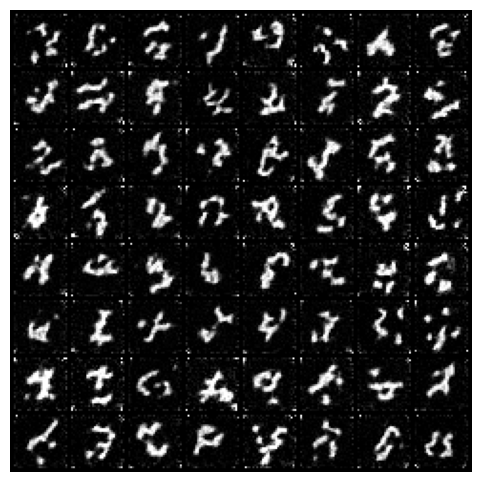

In [18]:
# Load the pre-trained model checkpoint
ckpt = torch.load('../models/U-net_concatenation_simple.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

The current results are not satisfactory, as it is challenging to identify any numbers clearly. However, there is still a lot to cover in this blog, which will showcase promising results.

#### Training Addition U-Net

The U-Net architecture with concatenation did not perform well. However, let’s proceed with training the U-Net architecture based on addition and determine whether it yields improved results or not.

We will be using following hyperparameters: **75 epochs** for training, a **mini-batch size** of 1**024**, and a **learning rate** of 10**e-3**. The training will be conducted on the **MNIST** dataset.

In [ ]:
# Set the device for computation
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
# Set the random seed for reproducibility
torch.manual_seed(123)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 75
batch_size = 1024
lr = 1e-3
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)


# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Load the MNIST dataset for training.
dataset = MNIST('../data/raw', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), '../models/U-net_addition_simple.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_61121/2660597194.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 809.571862 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 243.959811 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 164.519564 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 126.067683 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 103.485218 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 88.267114 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 78.058634 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 70.489177 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 65.118423 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 60.385226 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 56.624618 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 54.671379 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 52.594436 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 49.795894 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 48.178046 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 46.243017 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 45.201459 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 43.743870 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 42.626367 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 42.037244 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 41.111655 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 39.830374 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 38.880282 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 38.119577 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 37.275365 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 36.875070 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 35.684013 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 35.369238 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 34.896786 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 34.150219 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 33.678709 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 32.877294 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 32.544026 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 31.993053 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 31.784810 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 31.426250 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 30.675350 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 30.034492 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 30.239409 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 29.892888 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 29.368752 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 28.848741 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 28.879859 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 28.914929 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 28.555874 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 28.131802 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 28.163879 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 27.812041 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 27.629317 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 27.378222 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 27.108050 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 26.949904 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 26.518387 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 26.626724 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 26.549196 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 26.282754 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 26.372256 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 26.180175 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 25.962562 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 25.924999 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 25.430038 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 25.219837 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 25.245797 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 25.451797 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 25.099148 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.983037 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 24.997309 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 24.916694 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 24.789211 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 24.716281 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 24.543010 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 24.638277 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 24.443813 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 24.357715 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 24.396702 lr 2.2e-04


/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_61121/2660597194.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_61121/2141167881.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


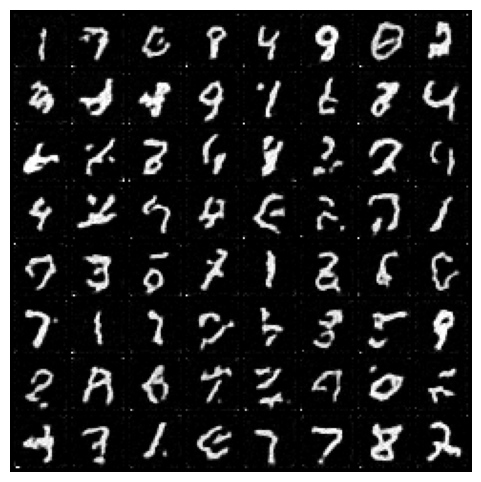

In [19]:
# Load the pre-trained model checkpoint
ckpt = torch.load('../models/U-net_addition_simple.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## Attention layer

### Building Attention Layers

When designing attention models, we typically work with three key components:

1. **Cross Attention:** Manages self and cross-attention mechanisms for sequences.
2. **Transformer Block:** Combines attention with neural network processing.
3. **Spatial Transformer:** Converts a spatial tensor in a U-Net to a sequential form and vice versa.

Let’s break down the underlying mathematics of attention models in simpler terms. In **QKV** (Query-Key-Value) attention, queries, keys, and values are represented as vectors. These vectors are used to connect elements on one side of a translation task (e.g., language or image) to the other side.

These vectors (**q**, **k**, **v**) are linearly related to the encoder’s hidden state vectors (**e**) and the decoder’s hidden state vectors (**h**):

![query, key and value](https://cdn-images-1.medium.com/max/11068/1*Oos1-uFVJRLahxne93d2nw.png)

To determine what to "pay attention" to, we compute the inner product (similarity) between each key (**k**) and query (**q**). To ensure the values are reasonable, these are normalized by the length of the query vectors (**qi**).

The final attention distribution is derived by applying the **softmax** function to these values:

![Applying Softmax](https://cdn-images-1.medium.com/max/13436/1*CR9S6fqnXACKE_IbwETMaw.png)

This attention distribution helps us select the most relevant features. For example, when translating the phrase **"This is cool"** from English to French, the correct translation (**"c’est cool"**) involves attending to both words at the same time, rather than translating them individually. Mathematically, we use the attention distribution to weight the values (**v_j**):

![attention distribution](https://cdn-images-1.medium.com/max/5600/1*yZTz2UuUhltTuZEM1LaPAA.png)

Now that we have a solid understanding of attention and the three attention modules we need to build, let's start coding them.

We’ll begin by implementing the first attention layer, **CrossAttention**.


### Cross attention

In [18]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim


        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

The **CrossAttention** class is a module designed to handle attention mechanisms in neural networks. It processes input tokens and, optionally, context information. When used for **self-attention**, it focuses on the relationships within the input tokens. In contrast, **cross-attention** considers the interaction between the input tokens and the context information. The module utilizes linear projections to transform the query, key, and value vectors. It then calculates score matrices, applies the **softmax** function to determine attention weights, and computes context vectors by combining the weighted values according to these attention weights. This mechanism allows the network to selectively focus on various parts of the input or context, thereby improving its ability to capture relevant information during the learning process. The **forward** method implements these operations and returns the context vectors after attention.


### Transformer block

In [19]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

The **TransformerBlock** class represents a fundamental component of a transformer model, integrating self-attention, cross-attention, and a feed-forward neural network. It takes input tensors with the shape `[batch, sequence_len, hidden_dim]` and, optionally, a context tensor with the shape `[batch, context_seq_len, context_dim]`. The block first applies self-attention or cross-attention, followed by **layer normalization** and a **residual connection** to ensure stable gradients and effective learning. In addition, the TransformerBlock includes a two-layer **MLP** with a **GELU** nonlinearity to introduce further non-linear transformations. The final output is obtained after processing through the TransformerBlock, combining attention mechanisms and non-linear transformations for rich feature representation.



### Spatial Transformer

In [20]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

## U-NET Architecture (with transformer)

In [21]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                  text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        # We addition the output of the tconv4 layer with h3
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


### Loss with denoising 

In [22]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

### Training

The advantage of training the U-Net architecture based on the attention layer is that, once trained, we can provide a specific number for our stable diffusion model to draw. Let’s initiate the training process with the following hyperparameters: 100 epochs, a mini-batch size of 1024, and a learning rate of 10e-3. The training will be performed using the **MNIST** dataset.

In [24]:
# Set the device for computation
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
# Set the random seed for reproducibility
torch.manual_seed(123)

# Set training hyperparameters
n_epochs =   100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

# Initialize a new UNet with Transformer model
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Load the MNIST dataset and create a data loader
dataset = MNIST('../data/raw', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        y = y.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), '../models/U-net_transformer.pth')

Using device: mps


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_70557/1072119730.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 802.094244 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 232.594893 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 152.326292 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 114.920668 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 93.968592 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 80.156503 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 70.672659 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 63.358430 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 58.086323 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 53.580048 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 49.763904 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 47.730200 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 45.865591 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 43.299035 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 41.732397 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 40.160526 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 39.389036 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 38.304283 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 37.317837 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 36.829417 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 36.152957 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 35.143382 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 34.246354 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 33.877023 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 33.181295 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 33.002000 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 31.740128 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 31.688615 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 31.084053 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 30.725867 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 30.458096 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 29.775709 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 29.481728 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 28.903806 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 28.864043 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 28.567430 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 27.887890 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 27.566298 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 27.499934 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 27.330122 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 26.863581 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 26.532250 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 26.627693 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 26.591394 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 26.219746 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 25.928066 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 25.962506 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 25.671802 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 25.553558 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 25.166974 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 24.996490 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 24.774862 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 24.449078 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 24.607015 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 24.548944 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 24.316625 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 24.322751 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 24.068076 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 23.846000 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 23.786322 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 23.333800 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 23.207931 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 23.081146 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 23.285979 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 23.053191 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 22.913415 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 22.876931 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 22.799365 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 22.570625 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 22.643512 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 22.294276 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 22.486573 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 22.347376 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 22.224685 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 22.215468 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 21.880785 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 22.157428 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 21.878904 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 21.897560 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 21.658589 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 21.644615 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 21.682507 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 21.481170 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 21.391980 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 21.277035 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 21.315883 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 21.322058 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 21.293714 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 21.198178 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 21.051088 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 20.814828 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 21.164879 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 20.772304 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 20.602763 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 20.847697 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 20.882816 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 20.610948 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 20.704200 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 20.609975 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 20.697970 lr 2.0e-04


/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_70557/1072119730.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/q0/t0rszn4j4lj2h8p868fzf6wm0000gn/T/ipykernel_70557/23555792.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


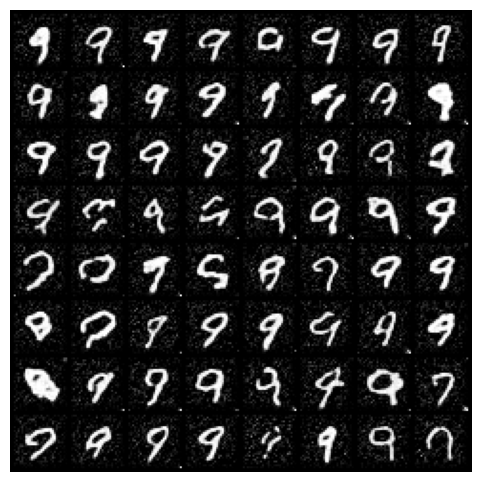

In [27]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('../models/U-net_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 9
###########
###########



# Set the batch size for generating samples
sample_batch_size = 64
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long, device=device))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()